# **TRAINING**

In [1]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'
os.environ['GRPC_VERBOSITY'] = 'ERROR'
os.environ['GRPC_TRACE'] = ''
os.environ['GRPC_DEFAULT_SSL_ROOTS_FILE_PATH'] = '/etc/ssl/certs/ca-certificates.crt'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras import Model as tfkModel

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)
print(tfk.__version__)

# Import other libraries
import matplotlib.pyplot as plt
import pandas as pd
from keras.utils import register_keras_serializable
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
from keras.callbacks import Callback
import IPython.display as display
# import graphviz
from PIL import Image
import matplotlib.gridspec as gridspec
import json

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

E0000 00:00:1731102416.267186  143148 common_lib.cc:798] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:479
E1108 21:46:56.307428306  143148 oauth2_credentials.cc:238]            oauth_fetch: UNKNOWN:C-ares status is not ARES_SUCCESS qtype=A name=metadata.google.internal. is_balancer=0: Domain name not found {created_time:"2024-11-08T21:46:56.307406946+00:00", grpc_status:2}


2.16.1
3.5.0


## **DISTRIBUTION DEFINITIONS**

In [2]:
def auto_select_accelerator():
    """
    Reference:
        * https://www.kaggle.com/mgornergoogle/getting-started-with-100-flowers-on-tpu
        * https://www.kaggle.com/xhlulu/ranzcr-efficientnet-tpu-training
    """
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.TPUStrategy(tpu)
        print("Running on TPU:", tpu.master())
    except ValueError:
        strategy = tf.distribute.get_strategy()
    print(f"Running on {strategy.num_replicas_in_sync} replicas")

    return strategy

In [3]:
# Setting che correct strategy for TPU / batch sizes
strategy = auto_select_accelerator()
numGPU = len(tf.config.list_physical_devices('GPU'))
numTPU = len(tf.config.list_logical_devices('TPU'))
print("Num GPUs Available: ", numGPU)
print("Num TPUs Available: ", numTPU)

I0000 00:00:1731102428.820489  143148 service.cc:145] XLA service 0x5d4ad2671490 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731102428.820536  143148 service.cc:153]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1731102428.820540  143148 service.cc:153]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1731102428.820543  143148 service.cc:153]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1731102428.820545  143148 service.cc:153]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1731102428.820548  143148 service.cc:153]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1731102428.820550  143148 service.cc:153]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1731102428.820553  143148 service.cc:153]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1731102428.820556  143148 service.cc:153]   StreamExecutor device (7): TPU, 2a886c8


Running on TPU: 
Running on 8 replicas
Num GPUs Available:  0
Num TPUs Available:  8


In [4]:
batch_size = 32
if numTPU != 0:
    batch_size = strategy.num_replicas_in_sync * 8

print(f"Batch size: {batch_size}")

Batch size: 64


## **DATA PREPROCESSING**

In [5]:
data_path = "/kaggle/input/blood-cells/cleaned_training_set.npz"

In [6]:
data = np.load(data_path, allow_pickle=True)
lst = data.files
X = data[lst[0]]
y = data[lst[1]]

# Convert values in data to int
X = X.astype(int)

# Normalize data to the range [0, 1]
X = (X / 255).astype('float32')

# Create a mapping from label string to values

# Convert labels to categorical format using one-hot encoding
y = tf.keras.utils.to_categorical(y)

# Encode the labels via LabelEncoding from stratch

# Split data into training, validation, and test sets, maintaining class distribution
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=seed, test_size=0.15, stratify=y)

# Splitting the training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=0.24, stratify=y_train_val)

In [7]:
del X, y # to free up resources

In [8]:
# Print the shapes of the loaded datasets
print("Training Data Shape:", X_train.shape)
print("Training Label Shape:", y_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Validation Label Shape:", y_val.shape)
print("Test Data Shape:", X_test.shape)
print("Test Label Shape:", y_test.shape)

Training Data Shape: (7725, 96, 96, 3)
Training Label Shape: (7725, 8)
Validation Data Shape: (2440, 96, 96, 3)
Validation Label Shape: (2440, 8)
Test Data Shape: (1794, 96, 96, 3)
Test Label Shape: (1794, 8)


In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).cache().shuffle(10240).batch(batch_size).repeat().prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).cache().shuffle(2048).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).cache().shuffle(2048).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [10]:
# Input shape for the model
input_shape = X_train.shape[1:]

# Output shape for the model
output_shape = y_train.shape[1]

steps_per_epoch = y_train.shape[0] // batch_size

print("Input Shape: ", input_shape)
print("Output Shape: ", output_shape)
print("Steps per epoch: ", steps_per_epoch)

Input Shape:  (96, 96, 3)
Output Shape:  8
Steps per epoch:  120


## **CUSTOM CALLBACKS AND METRICS DEFINITIONS**

In [11]:
# Custom implementation of ReduceLROnPlateau
class CustomReduceLROnPlateau(tf.keras.callbacks.Callback):
    def __init__(self, monitor='val_categorical_accuracy', factor=0.33, patience=20, min_lr=1e-8, verbose=1):
        super(CustomReduceLROnPlateau, self).__init__()
        self.monitor = monitor
        self.factor = factor
        self.patience = patience
        self.min_lr = min_lr
        self.verbose = verbose
        self.wait = 0
        self.best = None
        self.new_lr = None

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        
        # Initialize best metric if it's the first epoch
        if self.best is None:
            self.best = current
            return

        # Check if the monitored metric has improved
        if current > self.best:
            self.best = current
            self.wait = 0
        else:
            self.wait += 1

            # If patience is exceeded, reduce the learning rate
            if self.wait >= self.patience:
                old_lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
                if old_lr == self.min_lr:
                    return
                self.new_lr = max(old_lr * self.factor, self.min_lr)
                self.model.optimizer.learning_rate.assign(self.new_lr)
                
                if self.verbose > 0:
                    print(f"\nEpoch {epoch + 1}: reducing learning rate to {self.new_lr}.")
                
                self.wait = 0  # Reset patience counter

In [12]:
# Custom callback class for real-time plotting
class RealTimePlot(Callback):
    def on_train_begin(self, logs=None):
        # Initialize the lists that will store the metrics
        self.epochs = []
        self.train_loss = []
        self.val_loss = []
        self.train_acc = []
        self.val_acc = []

        # Set up the plot
        self.fig, (self.ax_loss, self.ax_acc) = plt.subplots(1, 2, figsize=(14, 5))
        plt.show()

    def on_epoch_end(self, epoch, logs=None):
        # Append the metrics to the lists
        self.epochs.append(epoch)
        self.train_loss.append(logs['loss'])
        self.val_loss.append(logs['val_loss'])
        self.train_acc.append(logs['categorical_accuracy'])
        self.val_acc.append(logs['val_categorical_accuracy'])

        # Clear the previous output
        display.clear_output(wait=True)

        # Plot training and validation loss
        self.ax_loss.clear()
        self.ax_loss.plot(self.epochs, self.train_loss, label='Training Loss')
        self.ax_loss.plot(self.epochs, self.val_loss, label='Validation Loss')
        self.ax_loss.set_title('Training and Validation Loss')
        self.ax_loss.set_xlabel('Epoch')
        self.ax_loss.set_ylabel('Loss')
        self.ax_loss.set_ylim(top=2.5, bottom=0.0)
        self.ax_loss.legend()

        # Plot training and validation accuracy
        self.ax_acc.clear()
        self.ax_acc.plot(self.epochs, self.train_acc, label='Training Accuracy')
        self.ax_acc.plot(self.epochs, self.val_acc, label='Validation Accuracy')
        self.ax_acc.set_title('Training and Validation Accuracy')
        self.ax_acc.set_xlabel('Epoch')
        self.ax_acc.set_ylabel('Accuracy')
        self.ax_acc.legend()

        # Redraw the updated plots
        display.display(self.fig)
        plt.pause(0.1)

In [13]:
class DisplayLearningRateCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Get the current learning rate from the optimizer and display it
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        print(f"Epoch {epoch+1} : Learning rate = {tf.keras.backend.get_value(lr)}")

## **MODEL DEFINITION**

In [14]:
@register_keras_serializable()
class CustomCastLayer(tfk.layers.Layer):
    def call(self, inputs):
        return tf.cast(inputs * 255, tf.uint8)

@register_keras_serializable()
class CustomAugmentLayer(tfk.layers.Layer):
    def __init__(self, max_rotation=30.0, **kwargs):
        super(CustomAugmentLayer, self).__init__(**kwargs)
        self.max_rotation = max_rotation / 360.00
        
    def call(self, inputs, training=False):
        if training:
            inputs = tf.image.random_flip_up_down(tf.image.random_flip_left_right(inputs))
            inputs = tf.image.random_brightness(inputs, max_delta=0.1)
            inputs = tf.image.random_contrast(inputs, lower=0.9, upper=1.1)
            
        return inputs

In [15]:
def create_model(shape=input_shape, n_labels=output_shape, convnext_trainable=False, #standard definitions
                 n_dense_layers=1, initial_dense_neurons=1024, min_neurons=64, # architecture definitions
                 include_dropout=False, dropout_rate=0.3, l2_lambda=0, # against overfitting
                 learning_rate=1e-4):
    
    # Seed for reproducibility
    tf.random.set_seed(seed)

    # The input layer
    inputs = tfkl.Input(shape=input_shape, name='Input')   

    # The two augmentation layers
    x = CustomCastLayer()(inputs)
    x = CustomAugmentLayer()(x, training=True)

    # The convnext layer with include top=False to take the convolutional part only
    convnext = tfk.applications.ConvNeXtXLarge(
                input_shape=input_shape,
                weights='imagenet',
                include_top=False
            )

    # Here we freeze the convnext to perform Tranfer Learning
    convnext.trainable = convnext_trainable

    x = convnext(x)
    x = tfkl.GlobalAveragePooling2D()(x)

    # Hidden layers building
    neurons = initial_dense_neurons
    for k in range(n_dense_layers):
        x = tfkl.Dense(units=neurons, activation='silu', name=f'Dense_layer_{k}', kernel_regularizer=tfk.regularizers.L2(l2_lambda))(x)
        if include_dropout:
            x = tfkl.Dropout(dropout_rate, name=f'Dropout_layer_{k}')(x)
        neurons = max(neurons // 2, min_neurons)
    outputs = tfkl.Dense(output_shape, activation='softmax', name='output_layer')(x)

    # Final model building
    model = tfk.Model(inputs=inputs, outputs=outputs, name='TF-CNN')

    # Compile the model
    loss = tfk.losses.CategoricalCrossentropy()
    # Metrics definition
    METRICS = [tfk.metrics.CategoricalAccuracy()]
    optimizer = tfk.optimizers.AdamW(learning_rate, weight_decay=l2_lambda)
    
    model.compile(loss=loss, optimizer=optimizer, metrics=METRICS)

    # Return the model
    return model

## **TRANSFER LEARNING**

In [25]:
# Best values found so far
n_dense_layers = 2
dropout_rate = 0.48
include_dropout = True
l2_lambda = 8e-2

epochs = 150

In [26]:
# Build the model with specified input and output shapes
with strategy.scope():
    model = create_model(n_dense_layers=n_dense_layers, include_dropout=True, dropout_rate=dropout_rate, l2_lambda=l2_lambda)

# Display a summary of the model architecture
model.summary(expand_nested=False, show_trainable=True)

Model: "TF-CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ Input (InputLayer)          │ (None, 96, 96, 3)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ custom_cast_layer_2         │ (None, 96, 96, 3)     │          0 │   -   │
│ (CustomCastLayer)           │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ custom_augment_layer_2      │ (None, 96, 96, 3)     │          0 │   -   │
│ (CustomAugmentLayer)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ convnext_xlarge             │ (None, 3, 3, 2048)    │ 348,147,9… │   N   │
│ (Functional)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d_2  │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ Dense_layer_0 (Dense)       │ (None, 1024)          │  2,098,176 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ Dropout_layer_0 (Dropout)   │ (None, 1024)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ Dense_layer_1 (Dense)       │ (None, 512)           │    524,800 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ Dropout_layer_1 (Dropout)   │ (None, 512)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ output_layer (Dense)        │ (None, 8)             │      4,104 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 350,775,048 (1.31 GB)

 Trainable params: 2,627,080 (10.02 MB)

 Non-trainable params: 348,147,968 (1.30 GB)

In [27]:
# Define the patience value for early stopping
patience = 15

# Create an EarlyStopping callback
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=patience,
    restore_best_weights=True
)

lr_reducer = CustomReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=10, min_lr=1e-8)
plot_callback = RealTimePlot()

# Store the callback in a list
callbacks = [early_stopping, plot_callback, lr_reducer, DisplayLearningRateCallback()]

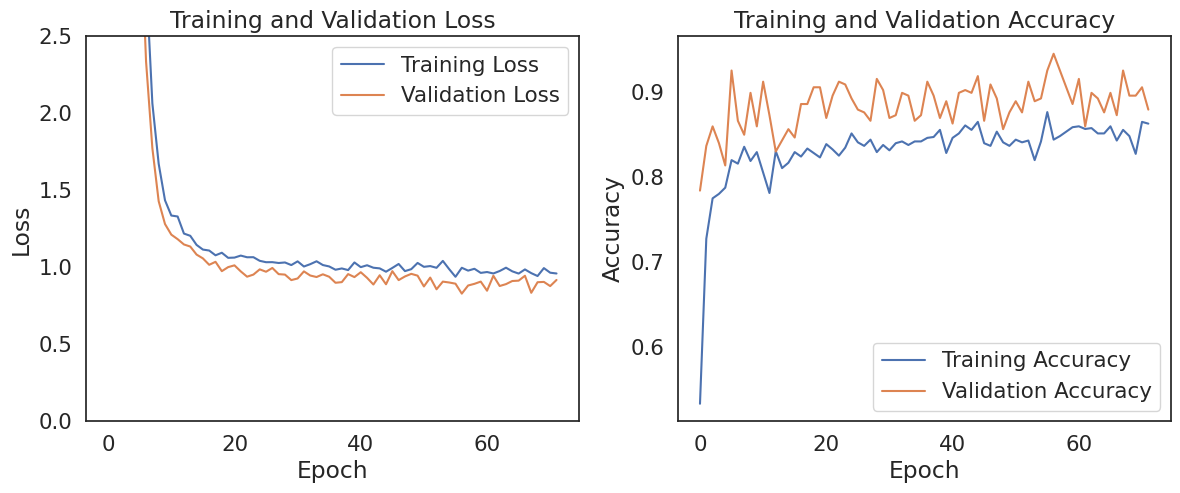

Epoch 72 : Learning rate = 1.56249996052793e-06
120/120 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - categorical_accuracy: 0.8639 - loss: 0.9494 - val_categorical_accuracy: 0.8787 - val_loss: 0.9175


In [28]:
# Train the model with early stopping callback
history = model.fit(
    train_dataset,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    callbacks=callbacks
).history

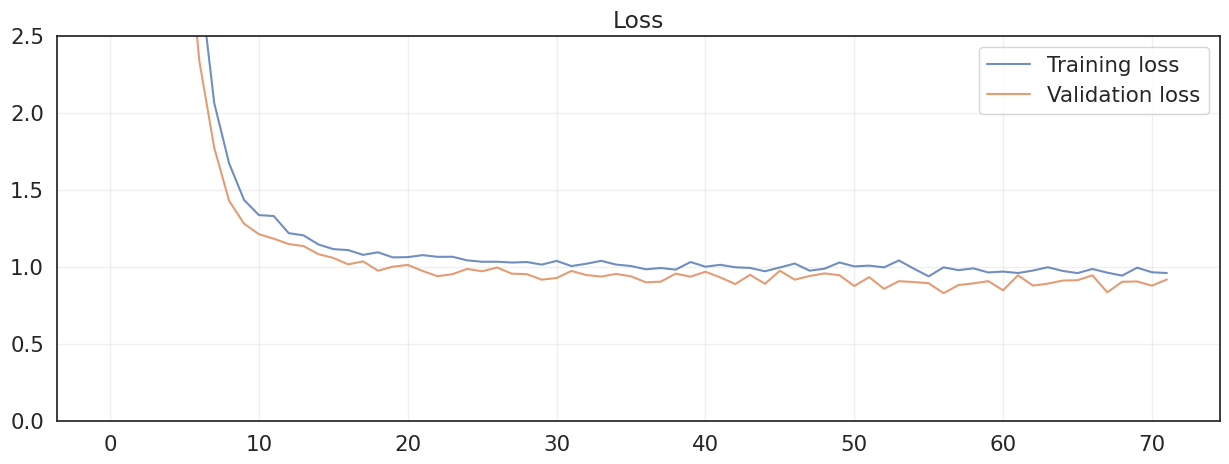

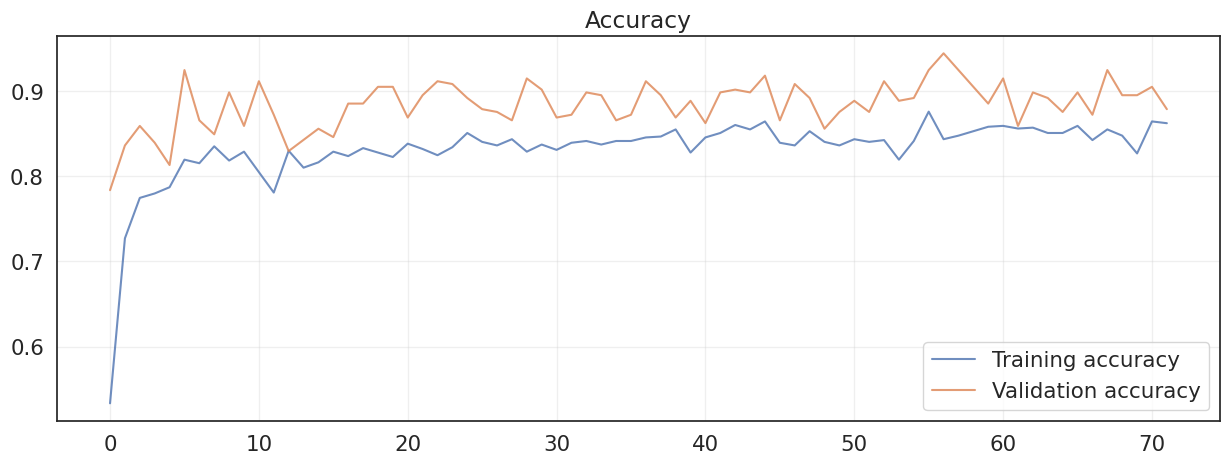

In [29]:
# Plot training and validation loss
plt.figure(figsize=(15, 5))
plt.plot(history['loss'], label='Training loss', alpha=.8)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
plt.ylim(top=2.5, bottom=0.0)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Plot training and validation accuracy
plt.figure(figsize=(15, 5))
plt.plot(history['categorical_accuracy'], label='Training accuracy', alpha=.8)
plt.plot(history['val_categorical_accuracy'], label='Validation accuracy', alpha=.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
# Save the trained model to a file with the accuracy included in the filename
with strategy.scope():
    model_weights_filename = 'MODEL.weights.h5'
    model.save_weights(model_weights_filename)

In [30]:
LABELS = [0, 1, 2, 3, 4, 5, 6, 7]

## **TRANSFER LEARNING EVALUATIONS**

In [31]:
def evaluations(model, ds, y_ds, labels, name):
    # Predict class probabilities and get predicted classes
    ds_predictions = model.predict(ds, verbose=0)
    ds_predictions = np.argmax(ds_predictions, axis=-1)
    
    # Extract ground truth classes
    ds_gt = np.argmax(y_ds, axis=-1)
    
    # Calculate and display training set accuracy
    ds_accuracy = accuracy_score(ds_gt, ds_predictions)
    print(f'Accuracy score over the {name} set: {round(ds_accuracy, 4)}')
    
    # Calculate and display training set precision
    ds_precision = precision_score(ds_gt, ds_predictions, average='weighted')
    print(f'Precision score over the {name} set: {round(ds_precision, 4)}')
    
    # Calculate and display training set recall
    ds_recall = recall_score(ds_gt, ds_predictions, average='weighted')
    print(f'Recall score over the {name} set: {round(ds_recall, 4)}')
    
    # Calculate and display training set F1 score
    ds_f1 = f1_score(ds_gt, ds_predictions, average='weighted')
    print(f'F1 score over the {name} set: {round(ds_f1, 4)}')
    
    # Compute the confusion matrix
    cm = confusion_matrix(ds_gt, ds_predictions)
    
    # Create labels combining confusion matrix values
    #labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)
    
    # Plot the confusion matrix with class labels
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=cm, fmt='', xticklabels=labels, yticklabels=labels, cmap='Blues')
    plt.xlabel('True labels')
    plt.ylabel('Predicted labels')
    plt.show()

Accuracy score over the training set: 0.901
Precision score over the training set: 0.9033
Recall score over the training set: 0.901
F1 score over the training set: 0.8998


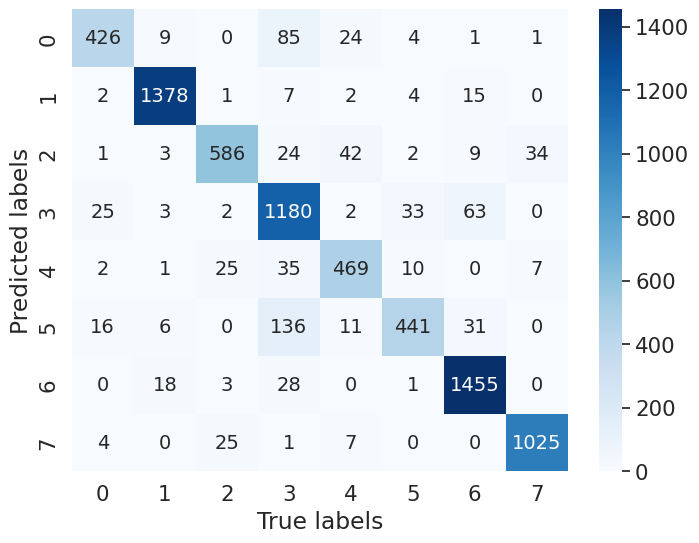

In [33]:
evaluations(model, ds=X_train, y_ds=y_train, labels=LABELS,name='training')

I0000 00:00:1731103270.865651  143895 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(a138d3c2ac759e7a:0:0), session_name()
I0000 00:00:1731103275.738593  143895 tpu_compile_op_common.cc:245] Compilation of a138d3c2ac759e7a:0:0 with session name  took 4.872885383s and succeeded
I0000 00:00:1731103275.761599  143895 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(a138d3c2ac759e7a:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_7342034257131083703", property.function_library_fingerprint = 5894229093112043267, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "", property.guaranteed_constants_size = 0, embedding_partit

Accuracy score over the validation set: 0.8963
Precision score over the validation set: 0.8997
Recall score over the validation set: 0.8963
F1 score over the validation set: 0.8952


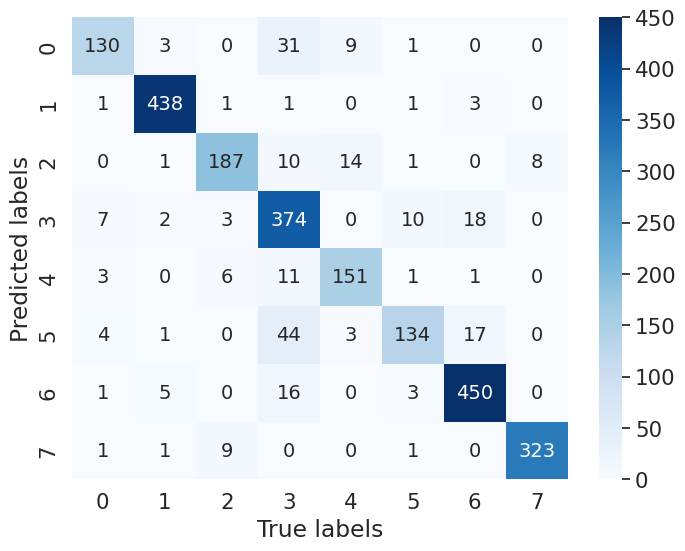

In [32]:
evaluations(model, ds=X_val, y_ds=y_val, labels=LABELS, name='validation')

Accuracy score over the test set: 0.9075
Precision score over the test set: 0.9113
Recall score over the test set: 0.9075
F1 score over the test set: 0.9056


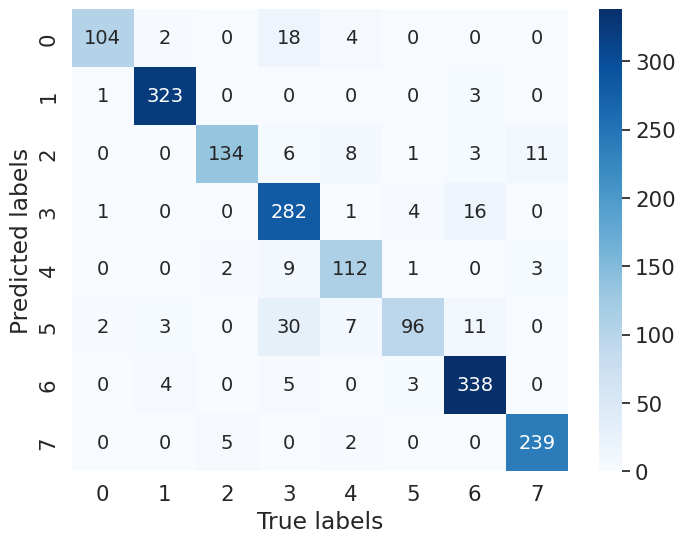

In [34]:
evaluations(model, ds=X_test, y_ds=y_test, labels=LABELS, name='test')

In [ ]:
del model

## **FINE TUNING**

In [ ]:
# Best values found so far
n_dense_layers = 2
dropout_rate = 0.35
include_dropout = True
l2_lambda = 1e-2

epochs = 30

In [ ]:
# Build the model with specified input and output shapes
with strategy.scope():
    model = create_model(n_dense_layers=n_dense_layers, include_dropout=True, dropout_rate=dropout_rate, l2_lambda=l2_lambda, convnext_trainable=True)

model.trainable = True
for layer in model.get_layer('convnext_xlarge').layers:
    if isinstance(layer, tfkl.LayerNormalization) or isinstance(layer, tfkl.Normalization):
        layer.trainable = False
        print(f"Layer {layer.name}, trainable {layer.trainable}")
    if type(layer).__name__ == 'LayerScale':
        layer.trainable = False
        print(f"Layer {layer.name}, trainable {layer.trainable}")

In [ ]:
model.summary()

In [ ]:
model.load_weights("MODEL.weights.h5")

In [ ]:
# Define the patience value for early stopping
patience = 12

# Create an EarlyStopping callback
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_binary_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

lr_reducer = CustomReduceLROnPlateau(monitor='val_binary_accuracy', factor=0.5, patience=5, min_lr=1e-8)
plot_callback = RealTimePlot()

# Store the callback in a list
callbacks = [lr_reducer]

In [ ]:
# Train the model with early stopping callback
history = model.fit(
    train_dataset,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    callbacks=callbacks
).history

## **FINE TUNING EVALUATIONS**

In [ ]:
evaluations(model, ds=X_train, y_ds=y_train, name='training')

In [ ]:
evaluations(model, ds=X_val, y_ds=y_val, name='validation')

In [ ]:
evaluations(model, ds=X_test, y_ds=y_test, name='test')